# Control of a holonomic robot using Jupyter Notebook

## Overall description of the package:

The task of this Jupyter Notebook is to replace the User Interface of the [first assignment](https://github.com/jerin-joy/ResearchTrack2_Assignment1) in the Research Track 2 course. It involves the control of a holonomic robot by using Jupyter Notebook widgets and monitors the data obtained by using various graphical tools in matplotlib.

More specifically, the first part of this Jupyter Notebook interface is able of:
- Starting or stopping the robot "random position" behaviour by using two buttons - Start and Stop.
- Setting the linear and angular velocities of the robot by using two sliders.
- Directly controlling the robot movements by using 5 buttons (Forward, Turn right, Backward, Turn Left and Stop)

Also, the second part of this package contains:
- A line plot for visualizing cmd_vel vs. actual velocity (for linear and angular velocity)
- A bar plot displaying the number of reached targets and cancelled targets.
- A hist plot showing the time required to reach targets.
- An xy graph showing the robot’s position and the orientation.

# Headers

Headers that are used in the entire package are given below.

In [1]:
%matplotlib widget

from ipywidgets import Button, Layout, ButtonStyle, GridBox, Box, HBox, VBox
import ipywidgets as widgets

import numpy as np
import collections

import rospy
import actionlib
import actionlib.msg
import rt2_assignment1.msg
import jupyros as jr
from geometry_msgs.msg import Twist
from rt2_assignment1.srv import Command
from rosgraph_msgs.msg import Clock
from nav_msgs.msg import Odometry

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.ticker as ticker


## Node initialization
Nodes used in ROS are initialized here. 

In [2]:
ui_client = rospy.ServiceProxy('/user_interface', Command)

rospy.init_node('jupyter_interface')

action_service = actionlib.SimpleActionServer(
        '/go_to_point', rt2_assignment1.msg.MoveAction, auto_start=False)

action_client = actionlib.SimpleActionClient('/go_to_point', rt2_assignment1.msg.MoveAction)

global random_status


# Widgets

## Buttons

Buttons for directional control and starting and stopping the robot is mentioned below. To simulate the keyboard layout the buttons are placed in a gridbox. 

In [3]:
#Buttons for directional control

up = Button(description='\u25b2', #direction='up',
                 layout=Layout(width='80%', grid_area='up'),
                 style=ButtonStyle(button_color='lightgray'))
down = Button(description='\u25bc', #direction='down',
                 layout=Layout(width='80%', grid_area='down'),
                 style=ButtonStyle(button_color='lightgray'))
right = Button(description='\u25b6', #direction='right',
                 layout=Layout(width='85%', grid_area='right'),
                 style=ButtonStyle(button_color='lightgray'))
left = Button(description='\u25c0', #direction='left',
                 layout=Layout(width='85%', grid_area='left'),
                 style=ButtonStyle(button_color='lightgray'))
stop_key = Button(description='STOP', #Stop button
                 layout=Layout(width='80%', grid_area='stop_key'),
                 style=ButtonStyle(button_color='orange'))

gb = GridBox(children=[up, down, right, left, stop_key],
        layout=Layout(
            width='100%',
            grid_template_rows='auto auto',
            grid_template_columns='33% 33% 33%',
            grid_template_areas='''
            ". up ."
            "left down right "
            ". stop_key ."
            ''')
       )

# display(gb)

#Buttons for starting and stopping of the robot.

start  = Button(description='START',
                 layout=Layout(width='80%', grid_area='start'),
                 style=ButtonStyle(button_color='lightgreen'))
stop  = Button(description='STOP',
                 layout=Layout(width='80%', grid_area='stop'),
                 style=ButtonStyle(button_color='lightblue'))

# h1 = VBox([start, stop])

g_all = GridBox(children=[start, stop],
        layout=Layout(
            width='100%',
            grid_template_rows='auto auto',
            grid_template_columns='31%',
            grid_template_areas='''
            ". start ."
            ". stop ."
            ''')
       )

# display(g_all)


## Sliders

Sliders that are used to control the robot by setting the linear and angular velocity of the robot are implemented here. When we increase the values in the slider, it gets published in the cmd_vel topic. 

In [4]:
lin_slider = widgets.FloatSlider(min=0.0, max=1.0, description='Lin. Velocity')
# display(lin_slider)

ang_slider = widgets.FloatSlider(min=0.0, max=1.0, description='Ang. Velocity')
# display(ang_slider)

# Control of the robot using widgets

This part of the package explains about the control of the robot using various Jupyter Notebook widgets such as buttons and sliders. 

## Start/Stop the robot using buttons
Using start and stop buttons, the Jupyter Notebook is able to start and stop the movement of the robot in the gazebo environment. When the stop button is pressed, the movement of the robot is stopped by cancelling the goal of the robot.

In [5]:
ui_client("stop")
random_status = False
output = widgets.Output()

def start_button(start):
    global random_status
    with output:
        slider_lin = 1.0
        slider_ang = 1.0
        rospy.set_param("slider_lin_scale",slider_lin)
        rospy.set_param("slider_ang_scale",slider_ang)
        ui_client("start")
        if random_status == True:
            print("Robot is already moving")
        random_status = True
        print('Start clicked')
        
def stop_button(stop):
    global random_status
    with output:
        ui_client("stop")
        if random_status == False:
            print("Robot is already stopped")
        random_status = False        
        print('Stop clicked')
        
start.on_click(start_button)
stop.on_click(stop_button)


## Setting the linear and angular velocity of the robot
In this part, the linear and angular velocity of the robot can be controlled using two sliders, each meant for controlling the linear speed and angular speed of the robot. 

In [6]:
pub = rospy.Publisher('cmd_vel', Twist, queue_size=10)

msg = Twist()

def on_value_change(change):
    if random_status == False:
        msg.linear.x = change['new']
        pub.publish(msg)
    else:
        slider_lin = change['new']
        rospy.set_param("slider_lin_scale",slider_lin)
        print("Random position movement active, velocity modulated")
    
def on_valueang_change(change):
    if random_status == False:
        msg.angular.z = change['new']
        pub.publish(msg)
    else:
        slider_ang = change['new']
        rospy.set_param("slider_ang_scale",slider_ang)
        print("Random position movement active, angular velocity modulated")

lin_slider.observe(on_value_change, names='value')
ang_slider.observe(on_valueang_change, names='value')

## Controlling the robot using 5 buttons
Here, the robot is controlled by using 5 buttons (Forward, Turn right, Backward, Turn Left and Stop). The buttons are directly published on the /cmd_vel topic.

In [7]:
def up_button(up):
    global random_status
    if random_status == True:
        ui_client("stop")
        print("Random go to point stopped, click again to start")
        random_status = False
    elif random_status == False:
        msg.linear.x = 1.0
        msg.angular.z = 0.0
        pub.publish(msg)
        print("Go straight")  
            
def down_button(down):
    global random_status
    if random_status == True:
        ui_client("stop")
        print("Random go to point stopped, click again to start")
        random_status = False
    elif random_status == False:
        msg.linear.x = -1.0
        msg.angular.z = 0.0
        pub.publish(msg)
        print("Go backwards")

def right_button(right):
    global random_status
    if random_status == True:
        ui_client("stop")
        print("Random go to point stopped, click again to start")
        random_status = False
    elif random_status == False:
        msg.linear.x = 0.0
        msg.angular.z = 1.0
        pub.publish(msg)
        print("Turn right")
            
def left_button(left):
    global random_status
    if random_status == True:
        ui_client("stop")
        print("Random go to point stopped, click again to start")
        random_status = False
    elif random_status == False:
        msg.linear.x = 0.0
        msg.angular.z = -1.0
        pub.publish(msg)
        print("Turn left")
            
def stop_button_click(stop_key):
    global random_status
    if random_status == True:
        ui_client("stop")
        print("Random go to point stopped, manual mode active.")
        random_status = False
    elif random_status == False:
        msg.linear.x = 0.0
        msg.angular.z = 0.0
        pub.publish(msg)
        print('Robot stopped')
        
up.on_click(up_button)
down.on_click(down_button)
right.on_click(right_button)
left.on_click(left_button)
stop_key.on_click(stop_button_click)

# display(gb)

## Widgets Display

Every widgets are displayed here. The widgets can be used to start/stop the robot by clicking Start/Stop button, change the linear/angular velocity by two sliders and control the robot using 5 buttons.   

### Start/Stop button

In [8]:
display(g_all)

GridBox(children=(Button(description='START', layout=Layout(grid_area='start', width='80%'), style=ButtonStyle…

### Change linear/angular velocity

In [9]:
display(lin_slider)
display(ang_slider)

FloatSlider(value=0.0, description='Lin. Velocity', max=1.0)

FloatSlider(value=0.0, description='Ang. Velocity', max=1.0)

### Control using 5 buttons

In [10]:
display(gb)

GridBox(children=(Button(description='▲', layout=Layout(grid_area='up', width='80%'), style=ButtonStyle(button…

# Plots

## Calculation

In [11]:
# target time and success rate calculation
number_of_targets = {'reached':0, 'cancelled':0}
time_to_target = []

def targetCallback(msg):
    global number_of_targets
    
    if msg.result.result:
        number_of_targets['reached']+=1   
        time_to_target.append(msg.header.stamp.secs - msg.feedback.goal_id.stamp.secs)
    else:
        number_of_targets['cancelled']+=1


rospy.Subscriber('/go_to_point/result', rt2_assignment1.msg.MoveAction, targetCallback)

## Plot Display

### cmd_vel vs actual velocity

### Number of reached targets and cancelled targets

{'reached': 0, 'cancelled': 0}


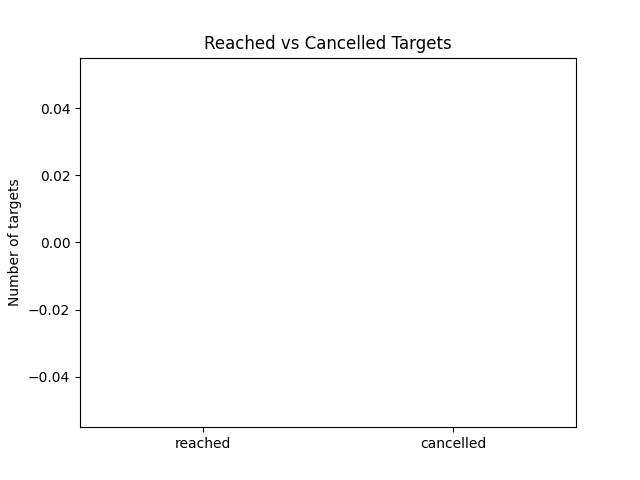

In [12]:
print(number_of_targets)

# Callback and data for the barplot with the result reached and cancelled
bar_plot = plt.figure()
ax_bar = bar_plot.add_subplot(111)
ax_bar.set_ylabel("Number of targets")
ax_bar.set_title("Reached vs Cancelled Targets")

plt.xticks(range(len(number_of_targets)), list(number_of_targets.keys()))
plot_value = plt.bar(range(len(number_of_targets)), list(number_of_targets.values()), align='center')


def animate_plot(i):
    for plots, val in zip(plot_value, number_of_targets.values()):
         plots.set_height(val)   
    return plot_value

animate_targets = animation.FuncAnimation(bar_plot, animate_plot, frames=50, interval=20, blit=True) 

### Time required to reach targets

### Robot's position vs orientation

Temp

In [13]:
from ipywidgets import Layout, Button, Box, VBox

# # Items flex proportionally to the weight and the left over space around the text
# # items_auto = [
# #     #Button(description='weight=1; auto', layout=Layout(flex='1 1 auto', width='auto'), button_style='danger'),
# #     Button(description='weight=3; auto', layout=Layout(width='7%', height='60px'), button_style='danger'),
# #     #Button(description='weight=1; auto', layout=Layout(flex='1 1 auto', width='auto'), button_style='danger'),
# #  ]

# up = widgets.Button(description="Up")
# box_layout = widgets.Layout(display='flex',
#                 flex_flow='column',
#                 align_items='center',
#                 width='75%')
# # box = widgets.HBox(children=[up],layout=box_layout)
# # display(box)

# # Items flex proportionally to the weight
# # items_0 = [
# #     Button(description='Left', layout=Layout(flex='1 1 0%', width='auto')),
# #     Button(description='Down', layout=Layout(flex='3 1 0%', width='auto')),
# #     Button(description='Right', layout=Layout(flex='1 1 0%', width='auto')),
# #  ]
# # box_layout = Layout(display='flex',
# #                     flex_flow='row',
# #                     align_items='stretch',
# #                     width='70%')
# # # box_auto = Box(children=items_auto, layout=box_layout)
# # box_0 = Box(children=items_0, layout=box_layout)
# # VBox([box_0])

# down = widgets.Button(description="Down")
# box_layout = widgets.Layout(display='flex',
#                 flex_flow='column',
#                 align_items='center',
#                 width='75%')
# # box = widgets.VBox(children=[down],layout=box_layout)
# # display(box)

# right = widgets.Button(description="Right")
# box_layout = widgets.Layout(display='flex',
#                 flex_flow='column',
#                 align_items='flex-end',
#                 width='75%')
# # box = widgets.VBox(children=[right],layout=box_layout)
# # display(box)

# left = widgets.Button(description="Left")
# box_layout = widgets.Layout(display='flex',
#                 flex_flow='column',
#                 align_items='flex-end',
#                 width='75%')

# gb = GridBox(children=[up, down, right, left],
#         layout=Layout(
#             width='100%',
#             grid_template_rows='auto auto',
#             grid_template_columns='33% 33% 33%',
#             grid_template_areas='''
#             ". up ."
#             "left down right "
#             ''')
#        )

# display(gb)